In [23]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [24]:
import os
base_dir = "/Users/adii/Downloads/archive"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')


In [25]:
model_name = "LeNet-5"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 1)

In [26]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

In [27]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, color_mode="grayscale", shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    color_mode="grayscale",
    shuffle=False,
)

test_generator = aug_datagen.flow_from_directory(
    test_path, class_mode="categorical", target_size=target_size, color_mode="grayscale", shuffle=True
)


Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [28]:
y_train = train_generator.labels
y_val = valid_generator.labels
y_test = test_generator.labels

print("Shape of y_train:", y_train.shape)
print("Size of y_train:", y_train.size)

print("Shape of y_val:", y_val.shape)
print("Size of y_val:", y_val.size)

print("Shape of y_test:", y_test.shape)
print("Size of y_test:", y_test.size)

print("Size of train_generator:", len(train_generator))
print("Size of valid_generator:", len(valid_generator))
print("Size of test_generator:", len(test_generator))

Shape of y_train: (5778,)
Size of y_train: 5778
Shape of y_val: (826,)
Size of y_val: 826
Shape of y_test: (1656,)
Size of y_test: 1656
Size of train_generator: 181
Size of valid_generator: 26
Size of test_generator: 52


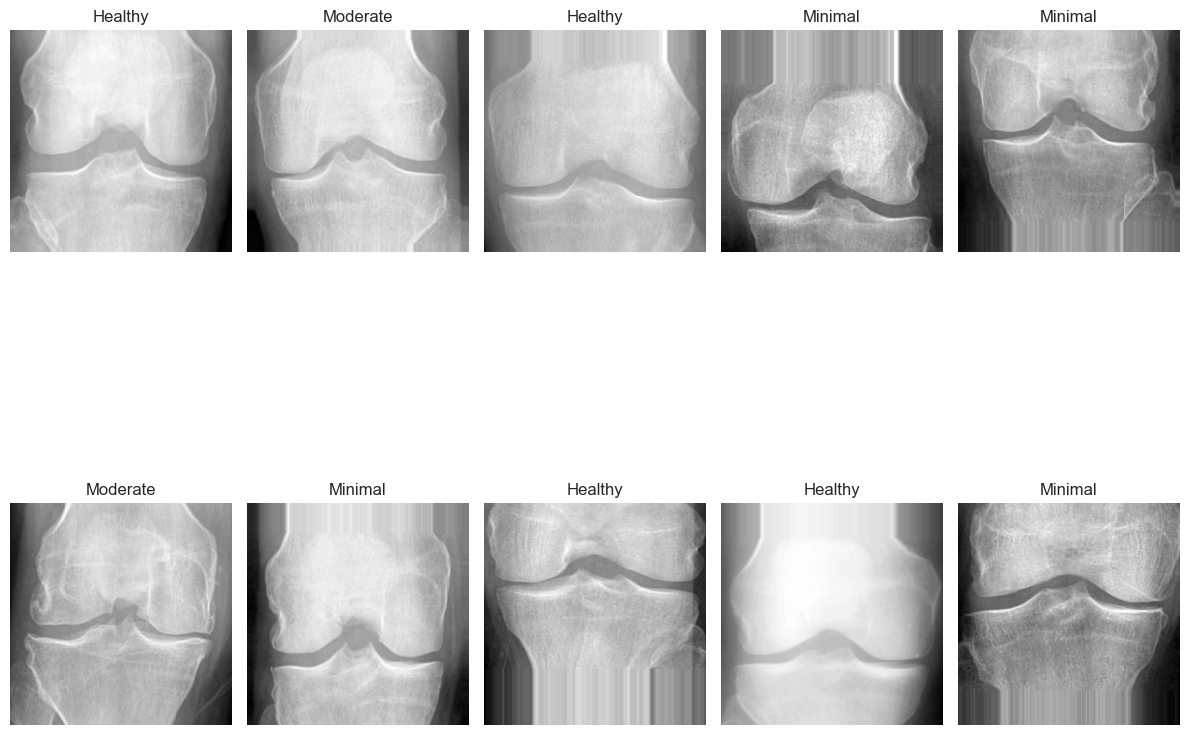

In [29]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    X_batch, Y_batch = train_generator.next()
    image = X_batch[0]
    dic = {0: 'Healthy', 1: 'Doubtful', 2: 'Minimal', 3: 'Moderate', 4: 'Severe'}
    plt.subplot(2, 5, i+1)
    plt.title(dic[np.argmax(Y_batch[0])])
    plt.axis('off')
    plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=img_shape))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dense(units=1, activation='sigmoid'))  # Assuming a binary classification task
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
# Hyperparameters of Conv2D
Conv2D(
    filters=32,  # You can adjust the number of filters as needed
    kernel_size=(3,3),  # Adjust the kernel size based on your requirements
    strides=(1, 1),
    padding="valid",
    activation="relu",  # You can choose the activation function here
    input_shape=img_shape  # Replace with your actual input shape
)

# Hyperparameters of MaxPooling2D
MaxPooling2D(
    pool_size=(2, 2),  # Adjust the pool size as necessary
    strides=None,
    padding="valid"
)


In [33]:
from tensorflow.keras.utils import plot_model

plot_model(cnn, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]


In [34]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5055118110236221,
 1: 1.1047801147227534,
 2: 0.7622691292875989,
 3: 1.5265521796565389,
 4: 6.679768786127168}

In [37]:
cnn.fit(train_generator, epochs=10, validation_data=valid_generator, class_weight=class_weights, callbacks=callbacks_list)


Epoch 1/10


2023-10-29 11:52:34.842336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


181/181 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.8000

2023-10-29 11:53:20.364152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


181/181 [==============================] - 47s 260ms/step - loss: 0.5004 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000 - lr: 2.7000e-05
Epoch 2/10
181/181 [==============================] - 48s 262ms/step - loss: 0.5004 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000 - lr: 2.7000e-05
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.8000
Epoch 3: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
181/181 [==============================] - 48s 266ms/step - loss: 0.5004 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000 - lr: 2.7000e-05
Epoch 4/10
181/181 [==============================] - 49s 270ms/step - loss: 0.5004 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000 - lr: 8.1000e-06
Epoch 5/10
181/181 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.8000
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
181/181 [=====================

In [38]:
test_accu = cnn.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

2023-10-29 12:01:07.571907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


52/52 [==============================] - 5s 96ms/step - loss: 0.5004 - accuracy: 0.8000
The testing accuracy is : 79.99995946884155 %
